<a href="https://colab.research.google.com/github/sukshithalle/RealTime-Parking-Analytics-Project/blob/main/RealTime_Parking_Pricing_Analytics_Capstone_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/sample_data/dataset (1).csv')
print(df.head())
print(df.columns)

   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   

  TrafficConditionNearby  QueueLength  IsSpecialDay LastUpdatedDate  \
0                    low            1             0      04-10-2016   
1                    low            1             0      04-10-2016   
2                    low            2             0      04-10-2016   
3                    low            2             0      04-10-2016   
4                    low            2             0      04-10-2016   

  LastUpdatedTime  
0        07:59:00  
1        08:25:00  
2        08:59:00  
3     

In [ ]:

print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB
None
ID                        0
SystemCodeNumber          0
Capacity                  

In [ ]:

def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-6)

def vehicle_type_weight(vehicle_type):
    weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.5}
    return weights.get(str(vehicle_type).lower(), 1.0)

In [ ]:
def baseline_linear_pricing(df, alpha=2.0):
    df = df.copy()
    df['BasePrice'] = 10.0
    df['OccupancyRatio'] = df['Occupancy'] / df['Capacity']
    df['Price_Model1'] = np.clip(
        df['BasePrice'] + alpha * df['OccupancyRatio'],
        df['BasePrice'] * 0.5,
        df['BasePrice'] * 2.0
    )
    return df

df = baseline_linear_pricing(df)

In [ ]:
traffic_map = {'low': 0, 'medium': 1, 'high': 2}
df['Traffic'] = df['TrafficConditionNearby'].map(traffic_map)


In [ ]:

print(df[['TrafficConditionNearby', 'Traffic']].head())

  TrafficConditionNearby  Traffic
0                    low      0.0
1                    low      0.0
2                    low      0.0
3                    low      0.0
4                    low      0.0


In [ ]:
# 1. Map categorical traffic to numeric
traffic_map = {'low': 0, 'medium': 1, 'high': 2}
df['Traffic'] = df['TrafficConditionNearby'].map(traffic_map)

# 2. Map vehicle type to weights
vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.5}
df['VehicleTypeWeight'] = df['VehicleType'].map(lambda x: vehicle_weights.get(x.lower(), 1.0))

# 3. Feature engineering
df['OccupancyRatio'] = df['Occupancy'] / df['Capacity']

# 4. Normalize helper
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-6)

# 5. Demand-based pricing model
params = {'alpha': 1.0, 'beta': 0.3, 'gamma': 0.2, 'delta': 0.5, 'epsilon': 0.4, 'lambda': 1.0}
df['RawDemand'] = (
    params['alpha'] * df['OccupancyRatio'] +
    params['beta'] * df['QueueLength'] -
    params['gamma'] * df['Traffic'] +
    params['delta'] * df['IsSpecialDay'] +
    params['epsilon'] * df['VehicleTypeWeight']
)
df['NormalizedDemand'] = normalize(df['RawDemand'])
df['BasePrice'] = 10.0
df['Price_Model2'] = np.clip(
    df['BasePrice'] * (1 + params['lambda'] * df['NormalizedDemand']),
    df['BasePrice'] * 0.5,
    df['BasePrice'] * 2.0
)

In [ ]:

print(df[['OccupancyRatio', 'QueueLength', 'Traffic', 'IsSpecialDay', 'VehicleTypeWeight', 'RawDemand', 'NormalizedDemand', 'Price_Model2']].head())

   OccupancyRatio  QueueLength  Traffic  IsSpecialDay  VehicleTypeWeight  \
0        0.105719            1      0.0             0                1.0   
1        0.110919            1      0.0             0                1.0   
2        0.138648            2      0.0             0                1.0   
3        0.185442            2      0.0             0                1.0   
4        0.259965            2      0.0             0                0.7   

   RawDemand  NormalizedDemand  Price_Model2  
0   0.805719          0.090637     10.906369  
1   0.810919          0.091567     10.915671  
2   1.138648          0.150196     11.501955  
3   1.185442          0.158567     11.585666  
4   1.139965          0.150431     11.504312  


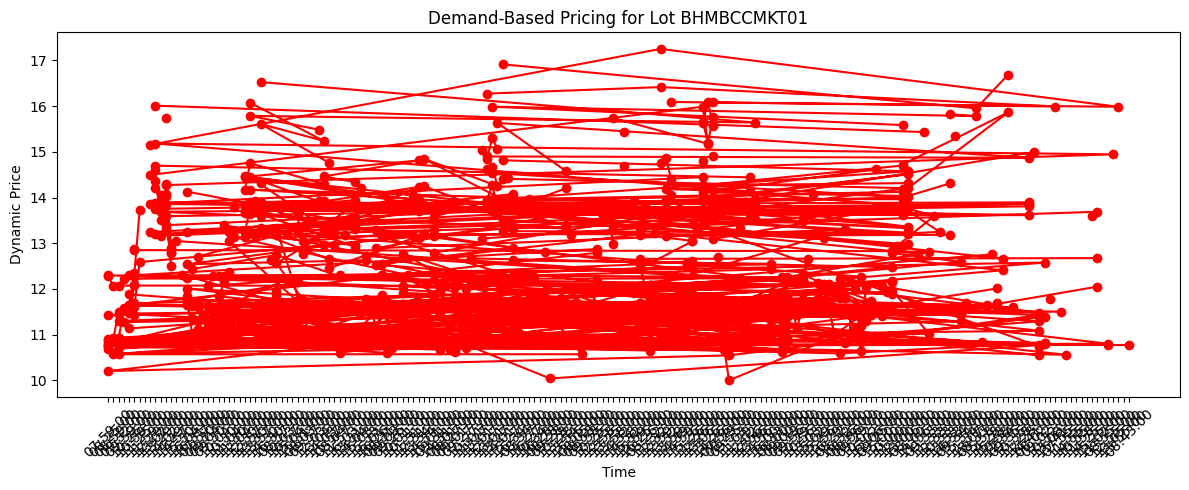

In [ ]:
import matplotlib.pyplot as plt

# Plot for a single parking lot (example: first SystemCodeNumber)
lot_id = df['SystemCodeNumber'].unique()[0]
df_lot = df[df['SystemCodeNumber'] == lot_id]

plt.figure(figsize=(12, 5))
plt.plot(df_lot['LastUpdatedTime'], df_lot['Price_Model2'], marker='o', color='red')  # 🔴 Set color here
plt.xlabel('Time')
plt.ylabel('Dynamic Price')
plt.title(f'Demand-Based Pricing for Lot {lot_id}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv('dynamic_pricing_results.csv', index=False)

In [ ]:
alpha = 2.0
df['Price_Model1'] = np.clip(
    df['BasePrice'] + alpha * df['OccupancyRatio'],
    df['BasePrice'] * 0.5,
    df['BasePrice'] * 2.0
)

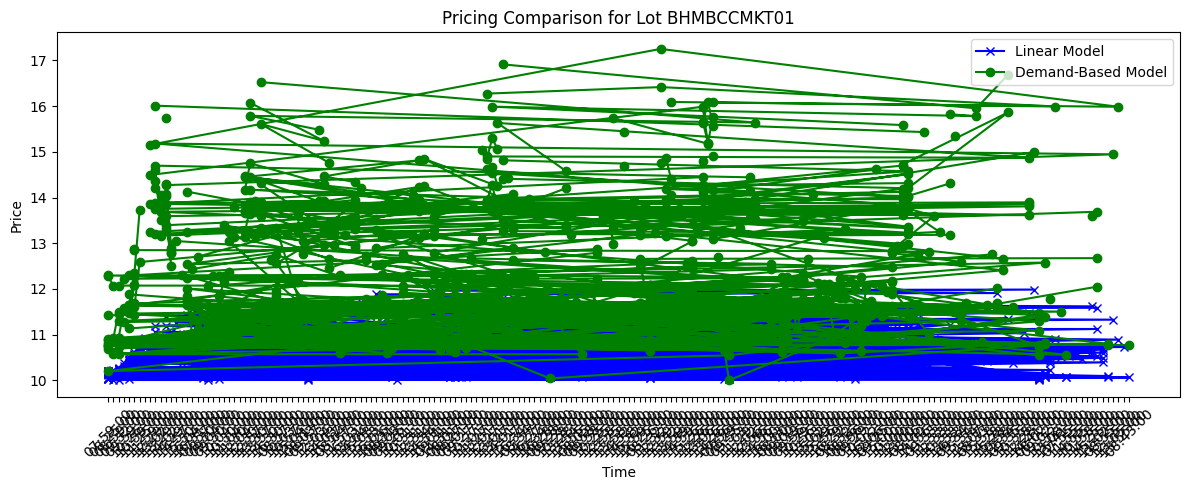

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 🔵 Blue for Model 1
plt.plot(df_lot['LastUpdatedTime'], df_lot['Price_Model1'], label='Linear Model', marker='x', color='blue')

# 🟢 Green for Model 2
plt.plot(df_lot['LastUpdatedTime'], df_lot['Price_Model2'], label='Demand-Based Model', marker='o', color='green')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Pricing Comparison for Lot {lot_id}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


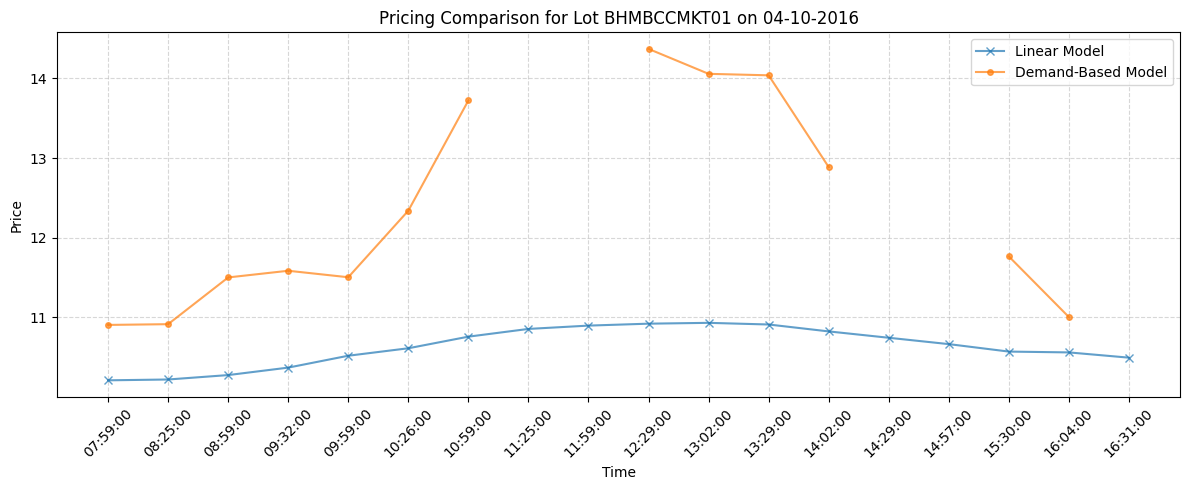

In [ ]:
import matplotlib.pyplot as plt

# If you want to plot for a single day:
single_day = df_lot['LastUpdatedDate'].unique()[0]
df_day = df_lot[df_lot['LastUpdatedDate'] == single_day]

plt.figure(figsize=(12,5))
plt.plot(df_day['LastUpdatedTime'], df_day['Price_Model1'], label='Linear Model', marker='x', linestyle='-', alpha=0.7)
plt.plot(df_day['LastUpdatedTime'], df_day['Price_Model2'], label='Demand-Based Model', marker='o', linestyle='-', alpha=0.7, markersize=4)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Pricing Comparison for Lot {lot_id} on {single_day}')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()